In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import albumentations as A
import os
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# clear the output 
from IPython.display import clear_output

# Clear the notebook output
clear_output(wait=True)

# Data Augmentation using Albumentations

Prevent overfitting by increasing dataset variability.


In [ ]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
])

In [ ]:
augmentation_path = '/kaggle/input/brain-tumor-classification-mri/Training/no_tumor'
output = '/kaggle/working/augmented_no_tumor' # Directory to save augmented images.

# to ensure the output directory exists
os.makedirs(output, exist_ok=True)

# Augmentation
for img in os.listdir(augmentation_path):
    image_path = os.path.join(augmentation_path, img)
    image = cv2.imread(image_path)
    augmented = transform(image=image)['image']
    
    # Save
    output_img_path = os.path.join(output, f"{os.path.splitext(img)[0]}_aug.jpg")
    # adding _aug suffix  to image name
    cv2.imwrite(output_img_path, augmented)

In [ ]:
train_data = []
train_labels = []
test_data = []
test_labels = []

# Reading the Data


In [ ]:
base_path = "/kaggle/input/brain-tumor-classification-mri"
augmented_path = "/kaggle/working"  #for augmented data

# Loop through Training and Testing directories
for dir in os.listdir(base_path):
    path = os.path.join(base_path, dir)  # Path to 'Training' or 'Testing'
    
    for sub_dir in os.listdir(path):  #each class
        sub_dir_path = os.path.join(path, sub_dir)  # path to subdirectory
        
        # Check if it's a valid directory
        if os.path.isdir(sub_dir_path):
            for img in os.listdir(sub_dir_path):  #each image in the subdirectory
                img_path = os.path.join(sub_dir_path, img)
                image = cv2.imread(img_path)
                if image is None:
                    continue  # Skip invalid files
                
                image = cv2.resize(image, (64, 64))  # Resize image
                image = image.flatten() / 255.0  # Normalize image
                
                # Append to appropriate list based on Training or Testing
                if dir == "Testing":
                    test_data.append(image)
                    test_labels.append(sub_dir) # Use subdirectory name as label
                else:  # For Training
                    train_data.append(image)
                    train_labels.append(sub_dir)

# Include augmented data from the /kaggle/working directory
augmented_no_tumor_path = os.path.join(augmented_path, "augmented_no_tumor")
if os.path.exists(augmented_no_tumor_path):
    for img in os.listdir(augmented_no_tumor_path):
        img_path = os.path.join(augmented_no_tumor_path, img)
        image = cv2.imread(img_path)
        if image is None:
            continue  # Skip invalid files
        
        image = cv2.resize(image, (64, 64))  # Resize image
        image = image.flatten() / 255.0  # Normalize image
        
        # Append augmented data under the 'no_tumor' label
        train_data.append(image)
        train_labels.append("no_tumor")  # Label as 'no_tumor'

# Convert to numpy arrays


In [ ]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

print(len(train_data), len(train_labels), len(test_data), len(test_labels))

# train_test_split


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [ ]:
ytrain

# PCA


In [ ]:
scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC

pca = PCA(n_components=0.98)
pca_train = pca.fit_transform(xtrain)
pca_test = pca.transform(xtest)
svm = SVC()

svm.fit(pca_train, ytrain)
y_pred = svm.predict(pca_test)
print(accuracy_score(ytest, y_pred))

**Using n_components=0.98 ensures that 98% of the variance in the data is preserved. This is a good approach when you are unsure of the ideal number of components.**


In [ ]:
print(classification_report(ytest, y_pred))

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(ytrain)
test_labels_encoded = label_encoder.transform(ytest)

In [ ]:
train_labels_encoded

In [ ]:
test_labels_encoded

In [ ]:
# Split the training data further into training and validation sets
xtrain, xval, ytrain, yval = train_test_split(pca_train, train_labels_encoded, test_size=0.2, random_state=42)


## Objective & constraints function of SVM Soft Margin


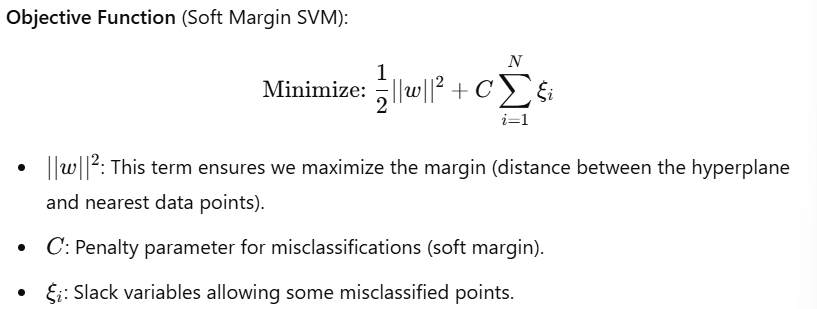


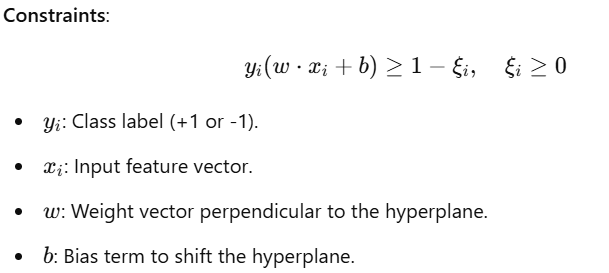


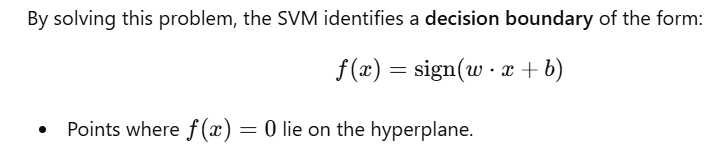
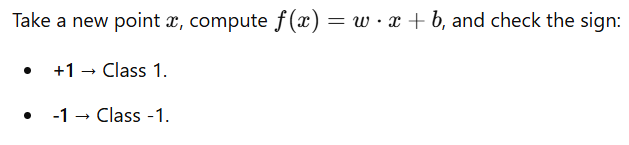


In [ ]:
pip install cvxopt


In [ ]:
from cvxopt import matrix, solvers
from itertools import combinations
from sklearn.metrics import accuracy_score, classification_report

## Gram Matrix 
'K = np.dot(X, X.T)' 
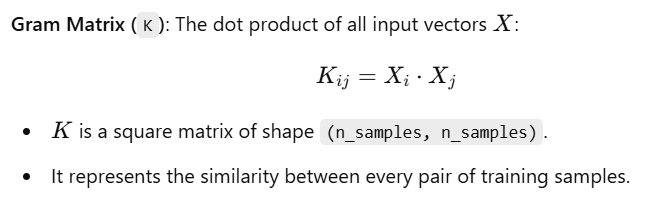

## the optimization Problem after adding the Lagrange multiplieir 
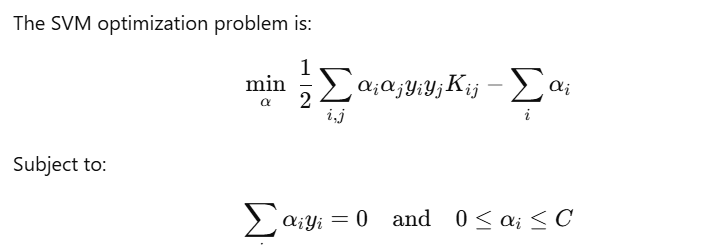
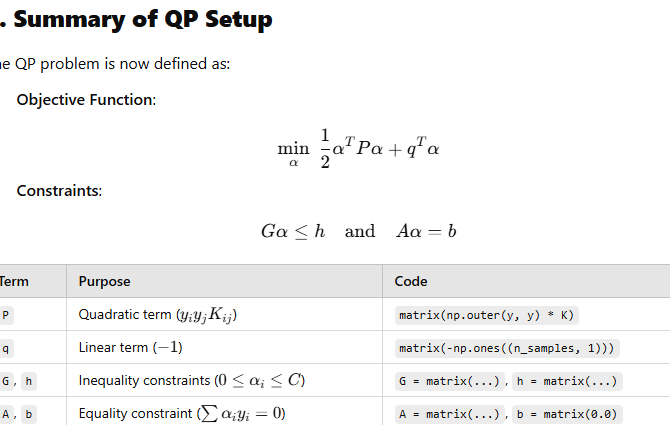

# Making the constraints in code 

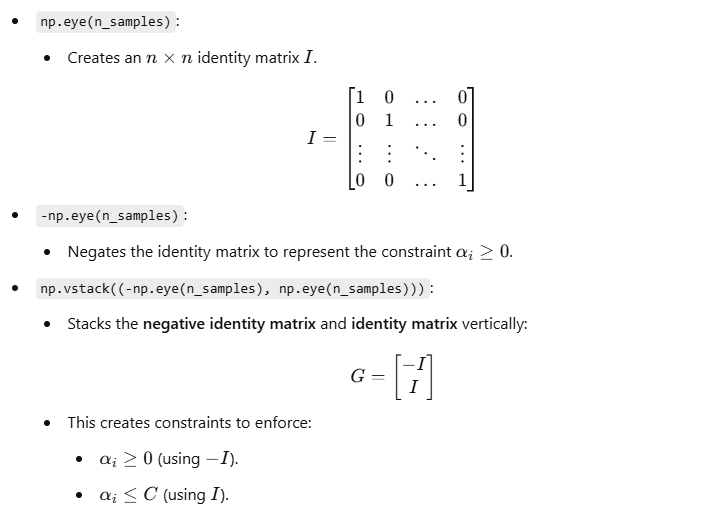
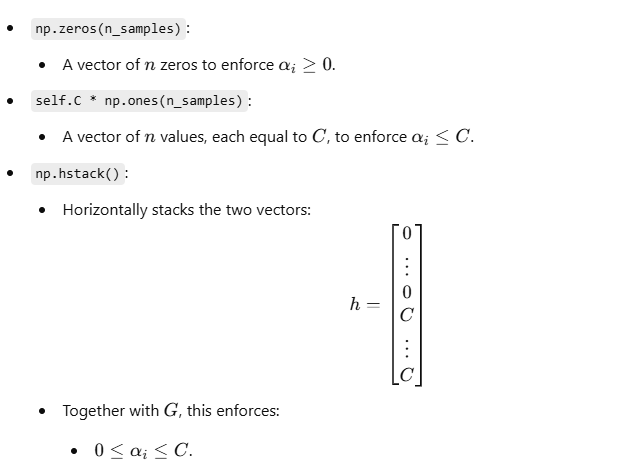

## What is outer product ?
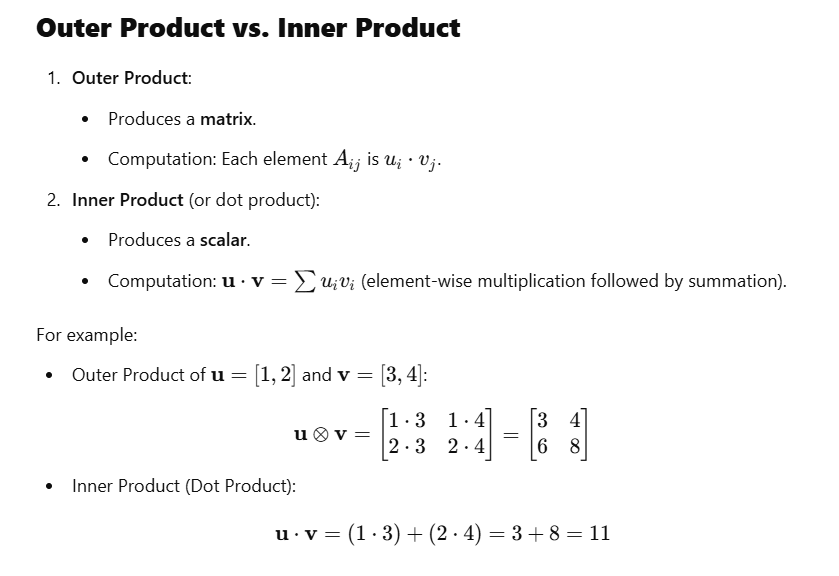

In [ ]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C  # Soft margin parameter
        #A larger value of𝐶 means 
        #the model penalizes misclassifications more
        self.w = None  # Weight vector
        self.b = 0     # Bias term

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Compute the Gram matrix (dot product between pairs of samples)
        #computes pairwise dot products of all input vectors
        K = np.dot(X, X.T) # dot product for similarity 

        # Setup the QP(Quadratic Programming) problem
        P = matrix(np.outer(y, y) * K) # y*y*K ->combine labels and gram matrix
        q = matrix(-np.ones((n_samples, 1)))# make a column matix with size n*1 filled with -1
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), self.C * np.ones(n_samples))))
        A = matrix(y.reshape(1, -1), tc='d')
        b = matrix(0.0)# matrix of single value

        # Solve the QP problem
        sol = solvers.qp(P, q, G, h, A, b) # solve to find lagrange multiplier
        alphas = np.array(sol['x']).flatten() #-> convert to 1D
        #sol['x'] ->contains the optimal lagrange
        #multiplier for each sample as a matix

        # Support vectors have non-zero alphas
        support_vector_idx = alphas > 1e-5 #0.00001 
        #->creates a boolean mask, marking the indices of all 
        #values that are greater than the threshold.
        #this small value not exactly zero
        #helps identify values of 
        #that are effectively non-zero while 
        #ignoring small noise introduced by the solver.
        self.alphas = alphas[support_vector_idx] #Extract Support Vectors
        self.support_vectors = X[support_vector_idx] #Extract Support Vectors' Feature Values

        self.support_vector_labels = y[support_vector_idx]#Extract Support Vectors' Labels

        # Compute weight vector
        self.w = np.sum(self.alphas[:, np.newaxis] * self.support_vector_labels[:, np.newaxis] * self.support_vectors, axis=0)
        # np.newaxis reshape to column vector for broadcasting
        # Compute bias
        self.b = np.mean(
            self.support_vector_labels - np.dot(self.support_vectors, self.w)
        )

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)


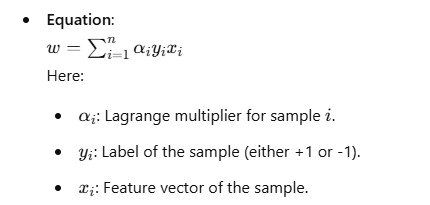

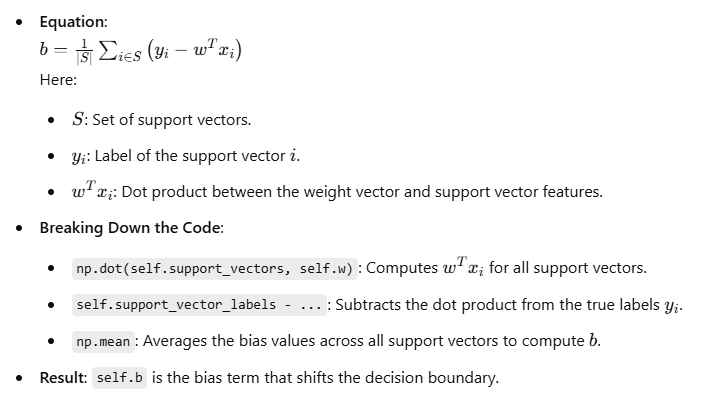

In [ ]:
class OvO_SVM: # one vs one
    def __init__(self, C=1.0):
        self.C = C
        self.models = {} # dictionary to store binary SVM models
        self.classes = None # Unique class labels

    def fit(self, X, y):
        self.classes = np.unique(y) # get unique classes from labels
        self.models = {}

        # Train binary SVMs for each pair of classes
        for (class1, class2) in combinations(self.classes, 2): #Creates all possible pairs of classes 
            print(f"Training for {class1} vs {class2}")
            # filter 
            #Select only the data points belonging to the current pair of classes
            X_binary = X[np.logical_or(y == class1, y == class2)]
            y_binary = y[np.logical_or(y == class1, y == class2)]
            y_binary = np.where(y_binary == class1, 1, -1)

            model = SVM(C=self.C)
            model.fit(X_binary, y_binary)
            self.models[(class1, class2)] = model

    def predict(self, X):
        #initializing votes matrix 
        #A 2D array with shape (num_samples,num_classes)initialized to zeros
        votes = np.zeros((X.shape[0], len(self.classes)))

        # Get predictions from all binary classifiers
        for (class1, class2), model in self.models.items():
            predictions = model.predict(X)
            votes[:, self.classes.tolist().index(class1)] += predictions == 1
            votes[:, self.classes.tolist().index(class2)] += predictions == -1
#self.classes.tolist().index(class1):
#Converts self.classes (array of all unique class labels) to a Python list.
#Finds the index of class1 in the list.
        
        # Class with the most votes wins
        return self.classes[np.argmax(votes, axis=1)]
        #For each row in the votes matrix (each test sample),
        #it finds the index of the column (class) with the highest vote count.

#np.argmax(votes, axis=1):
#For each row (sample), find the index of the maximum value (class with the highest votes).
#self.classes maps the indices back to the actual class labels


In [ ]:
ovo_svm = OvO_SVM(C=1.0)
ovo_svm.fit(xtrain, ytrain)

# Predict and evaluate on validation data
yval_pred = ovo_svm.predict(xval) 
print("Validation Accuracy:", accuracy_score(yval, yval_pred))
print("\nClassification Report:\n", classification_report(yval, yval_pred))

# Predict and evaluate on test data
ytest_pred = ovo_svm.predict(pca_test)
print("Test Accuracy:", accuracy_score(test_labels_encoded, ytest_pred))
print("\nClassification Report:\n", classification_report(test_labels_encoded, ytest_pred))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_boundaries_with_features_fixed(ovo_svm, X, y, feature_indices=(0, 1), step=0.001):
    """
    Plot decision boundaries for two selected features using the trained OvO SVM model with fixed feature alignment.

    Parameters:
    - ovo_svm: Trained OvO_SVM model.
    - X: Training data (numpy array or pandas DataFrame).
    - y: Labels for the training data.
    - feature_indices: Tuple specifying the indices of the two features to use for plotting.
    - step: Step size for the grid; larger values reduce memory usage but decrease resolution.
    """
    feature_1, feature_2 = feature_indices
    X_selected = X[:, [feature_1, feature_2]]

    # Define the grid with reduced resolution
    x_min, x_max = X_selected[:, 0].min() - 1, X_selected[:, 0].max() + 1
    y_min, y_max = X_selected[:, 1].min() - 1, X_selected[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                        np.arange(y_min, y_max, step))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Create a full-dimensional grid
    full_dim_grid = np.zeros((grid.shape[0], X.shape[1]))
    full_dim_grid[:, feature_1] = grid[:, 0]
    full_dim_grid[:, feature_2] = grid[:, 1]

    # Predict on grid points
    votes = np.zeros((grid.shape[0], len(ovo_svm.classes)))
    for (class1, class2), model in ovo_svm.models.items():
        predictions = model.predict(full_dim_grid)
        votes[:, ovo_svm.classes.tolist().index(class1)] += predictions == 1
        votes[:, ovo_svm.classes.tolist().index(class2)] += predictions == -1

    # Assign each point to the class with the most votes
    grid_predictions = ovo_svm.classes[np.argmax(votes, axis=1)]
    grid_predictions = grid_predictions.reshape(xx.shape)

    # Plot decision boundaries
    plt.contourf(xx, yy, grid_predictions, alpha=0.8, cmap=plt.cm.Paired)

    # Plot data points
    for class_label in ovo_svm.classes:
        plt.scatter(X_selected[y == class_label, 0], X_selected[y == class_label, 1], label=f"Class {class_label}")

    plt.legend()
    plt.title(f"Decision Boundaries (Features {feature_1} & {feature_2})")
    plt.xlabel(f"Feature {feature_1}")
    plt.ylabel(f"Feature {feature_2}")
    plt.show()

# Example usage
plot_decision_boundaries_with_features_fixed(ovo_svm, xtrain, ytrain, feature_indices=(0, 1), step=0.5)
